# Markov Chain Monte Carlo Sampling for Neural Networks - Stochastic Descent Langevin Dynamics (SGLD)

In the domain of learning from data $\mathcal{D}$ we generally distinguish between the frequentist and the Bayesian approach. Whilst the frequentist approach assumes one true solution $\hat{\boldsymbol{\theta}}$ of the model parameters for the problem at hand, being Bayesian includes modeling the parameters with a distribution and by this takes uncertainties into account. With the Bayesian approach we can express our knowledge about the model parameters prior of seeing any data. We can also express zero prior knowledge by using a uniform distribution assigning each parameter value the same probability. The more data the model sees, the more certain it is in its parameters, converging to the frequentist estimate when much data is observed.

In the frequentist approach, also called Maximum Likelihood Estimation (MLE), each individual data point of $\mathcal{D}=\{\mathbf{x}_i,y_i\}$ with $N$ data points is modeled with a Gaussian distribution:

$$p(y_i|\mathbf{x}_i, \boldsymbol{\theta}) = \frac{1}{\sigma\sqrt{2\pi}}\exp \left\{-\frac{1}{2\sigma^2}(y_i -\boldsymbol{\theta}^T\mathbf{x}_i)^2 \right\}$$ ,

where $\boldsymbol{\theta}$ denotes the model parameters. We are assuming a multidimensional output, but only a one-dimensional output for simplicity, though it actually can be of arbitrary dimension. Under the assumption of independent and identically distributed (i.i.d.) data, the probability for all data points factorizes (called the likelihood function):

$$p(\mathbf{y}|\mathbf{X},\boldsymbol{\theta}) = \prod_{i=1}^{N} p(y_i|\mathbf{x}_i, \boldsymbol{\theta})$$ ,

where $\mathbf{X}$ denotes the matrix of all data points with each data point $\mathbf{x}_i$ as a row vector. In Bayesian statistics we impose a prior distribution onto the model parameters $p(\boldsymbol{\theta})$, which is multiplied with the likelihood function from above. Bayes theorem is given by

$$
p(\boldsymbol{\theta}|\mathcal{D}) = \frac{p(\mathcal{D}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{p(\mathcal{D})} = \frac{p(\mathcal{D}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{\int p(\mathcal{D}|\boldsymbol{\theta})p(\boldsymbol{\theta})\,\mathrm{d}\boldsymbol{\theta}} ~.
$$

The likelihood that describes the probability of seeing this data $\mathcal{D}$ with our model parameters is multiplied by the probability of these parameters $p(\boldsymbol{\theta})$ our prior. To obtain a valid probability distribution this product must integrate to 1. This is ensured by normalizing with the evidence, the probability for seeing this particular data, which involves marginalising out all possible parameter distributions. A prediction on previously unseen data $(\mathbf{x}_*,y_*)$ can be done with

$$
p(y_*|\mathbf{x}_*,\mathcal{D}) = \int p(y_*|\mathbf{x}_*,\mathcal{D},\boldsymbol{\theta})p(\boldsymbol{\theta}|\mathcal{D})\,\mathrm{d}\boldsymbol{\theta} ~.
$$

Even for simple models that are non-linear evaluating the evidence and by this computing the posterior that is needed to make predictions can become intractable.

## Markov Chain Monte Carlo Sampling

*A great deal of the following explanations is inspired by the <a href="https://escholarship.org/content/qt4k8039zm/qt4k8039zm.pdf">PhD thesis from Sungjin Ahn</a>.*

Popular techniques for approximating the intractable posterior are sampling techniques namely Markov chain Monte Carlo sampling, which will be reviewed in the following. We reviewed two popular techniques for the simple exmaple of linear regression <a href="">here</a>, variational inference and Markov chain Monte Carlo (MCMC) sampling. As a quick recap, as the name implies MCMC methods combine Markov chains with Monte Carlo (MC) methods. A Markov chain is used to sample from a distribution of interest (e.g. our intractable posterior), and then by employing MC methods we can approximate the expectation whose exact solution is again to expensive to compute. MCMC methods make no assumption about the form of our posterior e.g. as to wether it can be approximated with a multivariate Gaussian. They only assume the posterior $p(\boldsymbol{\theta}|\mathcal{D})$ can be calculated up to normalization constant $Z$ meaning $p(\boldsymbol{\theta}|\mathcal{D})=\tilde{p}(\boldsymbol{\theta}|\mathcal{D})/Z$, where $Z$ denotes the evidence in our case (<a href="http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf">Bishop 2006</a>).

### Monte Carlo Integration

In machine learning we are often interested in computing an expectation of a function $\mathbb{E}\left[\mathbf{f}_{\boldsymbol{\theta}}\right]$ w.r.t. a distribution of the model parameters $p(\boldsymbol{\theta})$. In our case the distribution is defined by the posterior of our parameters $p(\boldsymbol{\theta}|\mathcal{D})$. Computing the expectation involves computing an integral, but we use Monte Carlo integration to approximate that integral by sampling from our posterior:

$$
\begin{aligned}
\mathbb{E}(\mathbf{f}) &= \int \mathbf{f}_{\boldsymbol{\theta}}(\mathbf{x}_*)p(\boldsymbol{\theta}|\boldsymbol{\Phi},\mathbf{y})d\boldsymbol{\theta} \\
&\approx \frac{1}{M} \sum_{i=1}^M \mathbf{f}_{\boldsymbol{\theta}_i}(\mathbf{x}_*) \quad \textrm{where} \quad \boldsymbol{\theta}_i \sim p(\boldsymbol{\theta}|\mathcal{D}) ~.
\end{aligned}
$$

The MC estimator is unbiased and consistent because by the <a href="https://en.wikipedia.org/wiki/Law_of_large_numbers#:~:text=Strong%20law,-The%20strong%20law&text=What%20this%20means%20is%20that,that%20of%20the%20weak%20law.">strong law of large numbers</a> it almost surely converges to the true value as the number of samples increases. Also, by the <a href="https://en.wikipedia.org/wiki/Central_limit_theorem">central limit theorem</a>, the variance of the MC estimator is 

$$\mathrm{Var}\left[\mathbf{f}\right] = \frac{\mathrm{Var}\left[\mathbf{f}_{\boldsymbol{\theta}_i}\right]}{M}~.$$

Thus, the more samples we analyse, the better our accuracy becomes, if the generated samples from the posterior $\boldsymbol{\theta}_i$ are independent. For complicated posterior distributions this is mostly impossible, but it still gives an unbiased estimate, if the number of generated samples is high enough (<a href="https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.446.9306&rep=rep1&type=pdf">Neal 1996</a>). The question remains of how to draw samples from our target distribution

### Markov Chains

To generate a set of dependent weights $\boldsymbol{\theta}_i$ a Markov chain can be utilized that has
the posterior $p(\boldsymbol{\theta}|\boldsymbol{\Phi},\mathbf{y})$ as its equilibrium distribution. Markov Chains are a sequence of events, where the probability of one event depends only on the state of the previous one. So, one
samples from a proposal distribution $q(\boldsymbol{\theta}|\boldsymbol{\theta}_i)$ and maintains a record of the current state $\boldsymbol{\theta}_i$. A Markov chain is defined by giving an initial distribution for the
first state of the chain $\boldsymbol{\theta}_1$ and a transition distribution for a new state $\boldsymbol{\theta}_{i+1}$ following from the current state $\boldsymbol{\theta}_i$. A stationary distribution q is established if the distribution
given by state $\boldsymbol{\theta}_{i+1}$ is the same as with state $\boldsymbol{\theta}_i$. If the drawn samples are dependent then early drawn samples need to be discarded, since they usually are not representatives
of the equilibrium distribution referred to as burn in phase. If the samples are dependent
the chain also needs much longer to reach its equilibrium distribution (<a href="https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.446.9306&rep=rep1&type=pdf">Neal 1996</a>).

### The Metropolis-Hastings Algorithm

A popular algorithm for MCMC sampling is Metropolis-Hastings (<a href="https://bayes.wustl.edu/Manual/EquationOfState.pdf">Metropolis et al. 1953</a>, <a href="https://academic.oup.com/biomet/article-abstract/57/1/97/284580?redirectedFrom=fulltext">Hastings 1970</a>). The acceptance probability Ai at time step i is given by

$$A_i(\boldsymbol{\theta}_*,\boldsymbol{\theta}_i) = \textrm{min} \left( 1, \frac{q(\boldsymbol{\theta}_i|\boldsymbol{\theta}_*)\tilde{p}(\boldsymbol{\theta}_*)}{q(\boldsymbol{\theta}_*|\boldsymbol{\theta}_i)\tilde{p}(\boldsymbol{\theta}_i)}  \right) ~,$$

where $\boldsymbol{\theta}_i$ denotes the current state and $\boldsymbol{\theta}_*$ the drawn proposal state, $\tilde{p}(\boldsymbol{\theta})$ is the prior of the model parameters. The normalization constants cancel out each other. After the acceptance probability is calculated, a random number $r$ is drawn from a Uniform distribution $r \sim \mathcal{U}(0,1)$. If $A_i > r$ the proposal state is accepted. The pseudo-code is described in Algorithm 1. For continous space, a simple choice for the proposal distribution is to use a Gaussian. One problem of using a Gaussian proposal distribution is that it does not consider to give a preference to an obvious direction of high acceptance probability which we can actually identify using the gradient of the target probability distribution.

***
__Algorithm 1__ Metropoli-Hastings algorithm
***
__Input:__ proposal distribution $q(\boldsymbol{\theta}_*|\boldsymbol{\theta})$<br>
&emsp;Draw intial state $\boldsymbol{\theta}_0$ from $p(\boldsymbol{\theta}_0)$<br>
&emsp;__for__ $t=0,1,\ldots,T$ __do__<br>
&emsp;&emsp;Draw a proposal state $\boldsymbol{\theta}_*$ from a proposal distribution $q(\boldsymbol{\theta}_{t+1}|\boldsymbol{\theta}_t)$<br>
&emsp;&emsp;Compute the accept-reject probability $\alpha(\boldsymbol{\theta}_*|\boldsymbol{\theta}_t)$<br>
&emsp;&emsp;Draw $u$ from a uniform distribution of range $[0,1]$.<br>
&emsp;&emsp;__if__ $\alpha_t > u$ __then__<br>
&emsp;&emsp;&emsp;Accept: $\boldsymbol{\theta}_{t+1} \leftarrow \boldsymbol{\theta}_*$<br>
&emsp;&emsp;__else__<br>
&emsp;&emsp;&emsp;Reject: $\boldsymbol{\theta}_{t+1} \leftarrow \boldsymbol{\theta}_t$<br>
&emsp;&emsp;__end if__<br>
&emsp;__end for__<br>
***

### Gibbs Sampling

In contrast to Metropolis-Hastings the Gibbs algorithm only samples from a subset (often a single component) of the posterior random variables while conditioning on the others. Thus, Gibbs sampling can be seen as a coordinate-wise sampling method.

More specifically, we consider a distribution of interest $p(\boldsymbol{\theta})=p(\theta_0,\ldots,\theta_D)$ from which we want to sample. We denote the $i^{\textrm{th}}$ component of $\boldsymbol{\theta}$ with $\theta_i$ and use $\boldsymbol{\theta}_{-i}$ to denote all others $\theta_0,\ldots,\theta_D$ except $\theta_i$. Gibbs sampling then uses the conditional distribution $p(\theta_i|\boldsymbol{\theta}_{-i})$ as a proposal function for $\theta_i$ while alternating the component index $i$.

Gibbs sampling can also be seen as a special case of the Metropolis-Hastings algorithm, where the proposal distribution is set to the conditional distribution $q(\theta_i|\boldsymbol{\theta})=p(\theta_i|\boldsymbol{\theta}_{-i})$. Thus, the acceptance ratio $alpha$ is always 1 and we always accept the proposal

$$
\frac{p(\theta_{i*}|\boldsymbol{\theta}_{-i})p(\boldsymbol{\theta}_{-i})}{p(\theta_i|\boldsymbol{\theta}_{-i})p(\boldsymbol{\theta}_{-i})} \times \frac{p(\theta_i|\boldsymbol{\theta}_{-i})}{p(\theta_{i*}|\boldsymbol{\theta}_{-i})} = 1 ~.
$$

The main limitation of Gibbs sampling is it must be easy to sample from the conditional posterior distribution.

***
__Algorithm 2__ Gibbs sampling
***
&emsp;Initialize $\boldsymbol{\theta}$<br>
&emsp;__for__ $t=1,\ldots,T$ __do__<br>
&emsp;&emsp;Sample $\theta_{0*}\sim p(\theta_{0*}|\boldsymbol{\theta}_{-0})$<br>
&emsp;&emsp;$\ldots$<br>
&emsp;&emsp;Sample $\theta_{D*}\sim p(\theta_{D*}|\boldsymbol{\theta}_{-D})$<br>
&emsp;&emsp;$\boldsymbol{\theta}_t \leftarrow \boldsymbol{\theta}_*$<br>
&emsp;__end for__
***

### Langevin Monte Carlo

As was already mentioned earlier the MCMC algortihm might be improved by considering the gradient of the target ditribution. <a href="https://projecteuclid.org/euclid.bj/1178291835">Langevin Monte Carlo</a> (Metropolis-Adjusted Langevin algorithm), uses the Langevin dynamics to obtain an efficient proposal distribution. The Langevin equation originated in statistical physics and is used to model the dynamics of molecular systems whose equilibrium distribution is $p(\boldsymbol{\theta})$. Langevin dynamics are modelled with the following equation also known as Langevin equation:

$$
\mathrm{d}\boldsymbol{\theta}_t = \frac{1}{2}\nabla_{\theta_t}\log p(\boldsymbol{\theta}_t) + \mathrm{d}\boldsymbol{\delta}_t ~,
$$

where $\boldsymbol{\theta}\in\mathbb{R}^D$ and $\boldsymbol{\delta}_t$ denotes the standard Brownian motion. Because in digital computers simulation of the continous dynamics from above cannot is not possible, we must first discretize the equation:

$$
\boldsymbol{\theta}_{t+1} \leftarrow \boldsymbol{\theta}_t + \frac{\eta_t}{2}\nabla_{\theta_t}\log p(\boldsymbol{\theta}_t) + \boldsymbol{\delta}_t \quad \textrm{with} \quad \boldsymbol{\delta} \sim \mathcal{N}(0,\eta_t) ~.
$$

Unfortunately, the above discretization leads to some error from the exact simulation. To overcome the discrepancy the Langevin Monte Carlo also computes an acceptance measure $\alpha$ analogous to Metropolis-Hastings with the proposal function

$$
q(\boldsymbol{\theta}_{t+1}|\boldsymbol{\theta}_t) = \mathcal{N}\left( \boldsymbol{\theta}_{t+1}|\boldsymbol{\theta}_t + \frac{\eta_t}{2}\nabla_{\theta_t}\log p(\boldsymbol{\theta}_t), \eta_t \right) ~.
$$

Note that as the step size $\eta_t \rightarrow 0$ the discretization error becomes negligible small and, thus, the acceptance probability converges to 1.

***
__Algorithm 3__ Langevin Monte Carlo
***
Initialize $\boldsymbol{\theta}$<br>
&emsp;__for__ $t=0,1,\ldots,T$ __do__<br>
&emsp;&emsp;$\delta_t \sim \mathcal{N}(0,\eta_t)$<br>
&emsp;&emsp;Propose $\boldsymbol{\theta}_* \leftarrow \boldsymbol{\theta}_t + \frac{\eta_t}{2}\nabla_{\theta_t}\log p(\boldsymbol{\theta}_t) + \delta_t$<br>
&emsp;&emsp;Compute the accept-reject probability $\alpha(\boldsymbol{\theta}_*|\boldsymbol{\theta}_t) = \frac{p(\boldsymbol{\theta}_*)\mathcal{N}\left( \boldsymbol{\theta}_t|\boldsymbol{\theta}_* + \frac{\eta_t}{2}\nabla_{\theta_*}\log p(\boldsymbol{\theta}_*), \eta_t \right)}{p(\boldsymbol{\theta}_t)\mathcal{N}\left( \boldsymbol{\theta}_*|\boldsymbol{\theta}_t + \frac{\eta_t}{2}\nabla_{\theta_t}\log p(\boldsymbol{\theta}_t), \eta_t \right)}$<br>
&emsp;&emsp;Draw $u$ from a uniform distribution of range $[0,1]$.<br>
&emsp;&emsp;__if__ $\alpha_t > u$ __then__<br>
&emsp;&emsp;&emsp;Accept: $\boldsymbol{\theta}_{t+1} \leftarrow \boldsymbol{\theta}_*$<br>
&emsp;&emsp;__else__<br>
&emsp;&emsp;&emsp;Reject: $\boldsymbol{\theta}_{t+1} \leftarrow \boldsymbol{\theta}_t$<br>
&emsp;&emsp;__end if__<br>
&emsp;__end for__<br>
***

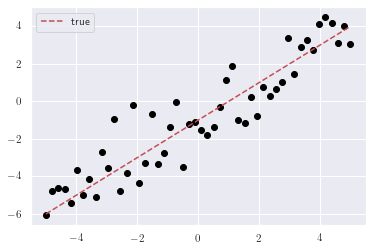

In [3]:
import matplotlib
%matplotlib inline

import torch
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

def model(x, weights):
    X = torch.tensor([(x**k).tolist() for k in range(len(weights))]).T
    return (X @ weights.unsqueeze(-1)).flatten()

no_samples = 50

x = torch.linspace(-5, 5, no_samples)

weights = torch.tensor([-1., 1.])
std_noise = 1.2

y_true = model(x, weights)
y_noisy = y_true + torch.randn(len(y_true)) * std_noise

plt.plot(x, y_true, color='r', linestyle='--', label='true')
plt.scatter(x, y_noisy, color='black')
plt.legend()
plt.show()

In [10]:
from typing import Callable
from tqdm import tqdm
import numpy as np
from torch import Tensor
from torch.distributions import Normal, Uniform

class MCMC:
    def __init__(self, start_params: Tensor, model: Callable, num_iter: int = 10000, burnin_iter: int = 5000):
        self.num_iter = num_iter
        self.burnin_iter = burnin_iter
        self.start_params = start_params
        self.model = model
    
    @staticmethod
    def log_Q(log_post: Callable, prop_p: Tensor, p: Tensor, lr: float) -> Tensor:
        p.requires_grad_()
        grad = torch.autograd.grad(log_post(p), p)[0]
        return -(torch.norm(prop_p - p + lr * grad) ** 2) / (4 * lr)

    def metropolis_adjusted_langevin(self, x: Tensor, y: Tensor, lr: float = 0.01) -> Tensor:
        
        self.chain = torch.zeros((self.num_iter, len(self.start_params)))
        self.chain[0] = self.start_params
        
        log_post = lambda p: self.log_posterior(x, y, p, self.model)
        
        for i in tqdm(range(self.num_iter-1)):
            p = self.chain[i].clone().requires_grad_()
            posterior_prob = log_post(p)
            grad = torch.autograd.grad(posterior_prob, p)[0]
            proposal = p.detach() - lr * grad + np.sqrt(2 * lr) * torch.randn(p.size())
            log_ratio = -log_post(proposal) + log_post(p) + self.log_Q(log_post, p, proposal, lr) - self.log_Q(log_post, proposal, p, lr)
            if torch.rand(1) < torch.exp(log_ratio):
                self.chain[i+1] = proposal.detach()
            else:
                self.chain[i+1] = self.chain[i]
        
        self.posterior_params = self.chain[self.burnin_iter:].mean(axis=0)
        
        return self.posterior_params
    
    def posterior_pred(self, x: Tensor) -> Tensor:
        y_pred = torch.tensor([self.model(x, c[:-1]).tolist() for c in self.chain[self.burnin_iter:]])
        return y_pred.mean(dim=0).flatten(), y_pred.std(dim=0).flatten()
    
    @staticmethod
    def log_prior(params: Tensor, prior_scale_weights: float = 1., prior_scale_noise: float = 5.) -> float:
        if isinstance(prior_scale_weights, (float, int)):
            prior_scale_weights = [prior_scale_weights for _ in range(len(params)-1)]
        log_prior_weights = torch.tensor([Normal(loc=0, scale=psw).log_prob(w).tolist() for w, psw in zip(params[:-1], prior_scale_weights)])
        log_prior_noise = Uniform(low=0., high=prior_scale_noise).log_prob(params[-1])
        #log_prior_weights = np.array([stats.norm.logpdf(w, loc=0, scale=psw) for w, psw in zip(params[:-1], prior_scale_weights)])
        #log_prior_noise = stats.uniform.logpdf(params[-1], loc=0, scale=prior_scale_noise)
        return log_prior_weights.sum() + log_prior_noise
    
    @staticmethod
    def log_likelihood(x: Tensor, y: Tensor, params: Tensor, model: Callable) -> float:
        y_pred = model(x, params[:-1])
        log_likelihoods = Normal(loc=y_pred, scale=params[-1]).log_prob(y)
        return torch.mean(log_likelihoods)
    
    def log_posterior(self, x: Tensor, y: Tensor, params: Tensor, model: Callable) -> float:
        return self.log_likelihood(x, y, params, model) + self.log_prior(params)

In [13]:
start_params_mcmc = torch.tensor([0.5, 0.5, 0.5])
mcmc = MCMC(start_params=start_params_mcmc, model=model, num_iter=100000, burnin_iter=10000)
posterior_params_mcmc = mcmc.metropolis_adjusted_langevin(x, y_noisy)

100%|██████████| 99999/99999 [08:30<00:00, 195.85it/s]


In [15]:
posterior_params_mcmc

tensor([ 1.1178, -2.1387,  1.1601])

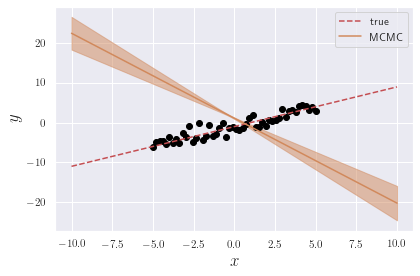

In [14]:
x_pred = torch.linspace(-10, 10, 1000)

y_true_pred = model(x_pred, weights)

y_pred_mcmc_mean, y_pred_mcmc_std = mcmc.posterior_pred(x_pred)

plt.plot(x_pred, y_true_pred, color='r', linestyle='--', label='true')
plt.plot(x_pred, y_pred_mcmc_mean, label='MCMC', color='#D1895C')
plt.fill_between(x_pred, y_pred_mcmc_mean + 2 * y_pred_mcmc_std, y_pred_mcmc_mean - 2 * y_pred_mcmc_std, color='#D1895C', alpha=0.5)
plt.scatter(x, y_noisy, color='black')
plt.legend()
plt.xlabel(r'$x$', fontsize=17)
plt.ylabel(r'$y$', fontsize=17)
plt.tight_layout()
plt.savefig('reg_mcmc_vi.pdf', bbox_inches='tight')
plt.show()

### Scalability Issues

For large-scale problems traditional MCMC algorithms get into trouble because they require $O(N)$ computations per iteration, e.g. the Metropolis-Hastings makes it necessary to evaluate the posterior $p(\boldsymbol{\theta})\prod_{i=1}^{N}p(\mathbf{x}_i|\boldsymbol{\theta})$ (up to a normalization constant) in both the numerator and the demoniator of the acceptance criterion $\alpha$. In general, the accept-reject test is statistically inefficient as well because the performed computation is wasteful if the proposal is rejected. Further, the Langevin Monte Carlo algorithm requires computing the gradient also needing $O(N)$ computations. Although Gibbs sampling is free from the accept-reject test, its limitations lie in the sampling from the conditional posterior, which often cannot be computed.

When a data set consits of billion data points traditional MCMC algorithms will not even have generated a single sample when learning algorithms based on stochastic gradient may already be making fairly good predictions (<a href="https://leon.bottou.org/publications/pdf/mloptbook-2011.pdf">Bottou and Bousquet 2008</a>).

## Stochastic Gradient Langevin Dynamics

Remedy comes in the form of stochastic gradient Langevin dynamics (SGLD), an algorithm proposed by <a href="http://www.stats.ox.ac.uk/~teh/research/compstats/WelTeh2011a.pdf">Welling and Teh (2011)</a> that overcomes the scalability issues of traditional MCMC algorithms and by this makes them applicable in the domain of models with many parameters and large data sets e.g. for neural networks. As the name suggests SGLD is related to the Langevin Monte Carlo algorithm with the general discretization

$$
\boldsymbol{\theta}_{t+1} \leftarrow \boldsymbol{\theta}_t + \frac{\eta_t}{2}\nabla_{\theta_t}\log p(\boldsymbol{\theta}_t|\mathcal{D}) + \delta_t~, \quad \textrm{with} \quad \delta_t \sim \mathcal{N}(0,\eta_t) ~,
$$

where the gradient of the log posterior is given by

$$
\nabla_{\theta_t}\log p(\boldsymbol{\theta}|\mathcal{D}) = \nabla_{\theta_t}\log p(\boldsymbol{\theta}_t) + \sum_{i=1}^{N}\nabla_{\theta_t}\log p(\mathbf{x}_i|\boldsymbol{\theta}_t)
$$

and the equilibrium distribution is given by the true posterior $p(\boldsymbol{\theta}|\mathcal{D})$. SGLD now applies to major changes compared to Langevin Monte Carlo in order to obtain the desired large-scale MCMC sampling method. First, the exact gradient is replaced with a stochastic one that can be calculated per mini-batch of size $n\ll N$. A mini-batch $\mathbf{X}_t^n$ is randomly sampled from the entire data set at every iteration t. Thus, the resulting update equation becomes

$$
\boldsymbol{\theta}_{t+1} \leftarrow \boldsymbol{\theta}_t + \frac{\eta_t}{2} \left\{ \nabla_{\theta_t}\log p(\boldsymbol{\theta}_t) + \frac{N}{n} \sum_{\mathbf{x}\in\mathbf{X}_t^n} \nabla_{\theta_t}\log p(\mathbf{x}|\boldsymbol{\theta}_t) \right\} + \delta_t~, \quad \textrm{with} \quad \delta_t \sim \mathcal{N}(0,\eta_t) ~.
$$

Second, SGLD omits the accept-reject test simply accepting all states, which eliminates the second source of $O(N)$ computations. Thus, the overall complexity becomes $O(n)$. The step-size (or learning rate $\eta_t$) must just fulfill two criteria so that samples from the true posterior are generated:

$$
\sum_{t=1}^{\infty}\eta_t=\infty ~, \quad \sum_{t=1}^{\infty}\eta_t^2<\infty ~.
$$

SGLD works because the induced noise during every parameter update dominates the difference in the gradients between each sampled mini-batch and the "true" gradient if we were to consider the whole data set at once, which will be briefly sketched in the following. We assume our loss per mini-batch $\mathcal{L}_{\textrm{MB(t)}}$ consists of the "true" loss $\mathcal{L}$ for the whole data set and a random noise part $\gamma_t$, which we assume to be Gaussian $\gamma_t\sim\mathcal{N}(0,\sigma_{\gamma_t})$:

$$
\mathcal{L}_{\textrm{MB(t)}}(\boldsymbol{\theta}) = \mathcal{L}(\boldsymbol{\theta}) + \gamma_t ~.
$$

Following from that, to ensure the injected noise dominates the noise per mini-batch, the variance of the parameter update must be lower than $\gamma_t$

$$
\begin{gathered}
    \begin{aligned}
    \textrm{Var}[\eta_t\gamma_t] &= \mathbb{E}[\eta_t^2\gamma_t^2] - \mathbb{E}[\eta_t\gamma_t]^2 \\
    &= \mathbb{E}[\eta_t^2]\mathbb{E}[\gamma_t^2] - \mathbb{E}[\eta_t]^2\mathbb{E}[\gamma_t]^2 \\
    &= \eta_t^2 \sigma_{\gamma_t}^2 - \eta_t^2 \cdot 0 ~, \\
    \end{aligned}\\
\textrm{with} \quad \mathbb{E}[\gamma_t^2] = \textrm{Var}[\gamma_t] + \mathbb{E}[\gamma_t] = \sigma_{\gamma_t}^2 + 0 ~,
\end{gathered}
$$

which states the variance of the mini-batch loss is proportional to the square of the learning rate $\textrm{Var}[\eta_t\gamma_t] \propto \eta_t^2$. If we now set the variance of the noise proportional to the learning rate, we ensure the added noise always dominates the mini-batch noise.

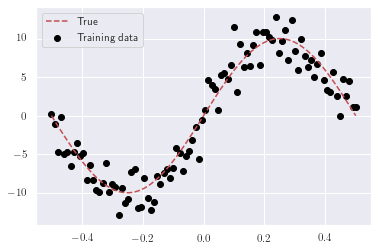

In [1]:
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

def f(x: torch.Tensor, sigma: float) -> torch.Tensor:
    epsilon = torch.randn(*x.shape) * sigma
    return 10 * torch.sin(2 * np.pi * (x)) + epsilon.to(x.device)

train_size = 96
sigma = 2.0

x = torch.linspace(-0.5, 0.5, train_size).reshape(-1, 1).type(dtype)
y = f(x, sigma=sigma).type(dtype)
y_true = f(x, sigma=0.0)

plt.scatter(x.cpu(), y.cpu(), color='black', label='Training data')
plt.plot(x.cpu(), y_true.cpu(), label='True', color='r', linestyle='--')
plt.legend()
plt.show()

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    
    def __init__(self, in_features: int = 1, out_features: int = 1):
        super(Model, self).__init__()
        
        self.layer1 = nn.Linear(in_features, 20)
        self.layer2 = nn.Linear(20, 20)
        self.layer3 = nn.Linear(20, out_features)
    
    def forward(self, x: torch.Tensor) -> (torch.Tensor):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [3]:
from typing import Generator
from torch.optim import Optimizer

class SGLD(Optimizer):

    def __init__(self, params: Generator[torch.Tensor, None, None], lr: float, weight_decay: float = 0., 
                 glr: str = 'var'):

        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr, weight_decay=weight_decay)
        self.glr = glr

        super(SGLD, self).__init__(params, defaults)

    def step(self) -> torch.Tensor:

        loss = None

        for group in self.param_groups:

            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p += weight_decay * p.data
                
                langevin_noise = torch.empty(p.data.size()).normal_().to(d_p.device)
                if self.glr == 'var':
                    p.data += -group['lr'] * 0.5 * d_p + np.sqrt(group['lr']) * langevin_noise
                else:
                    p.data += -group['lr'] * 0.5 * d_p + group['lr'] * langevin_noise

        return loss

In [4]:
def calc_uncert(preds: [torch.Tensor], reduction: str = 'mean') -> (torch.Tensor, torch.Tensor, torch.Tensor):
    preds = torch.cat(preds, dim=0)
    epi = torch.var(preds[:,:,0], dim=0)
    ale = torch.mean(preds[:,:,1], dim=0)#.exp()
    uncert = ale + epi
    if reduction == 'mean':
        return ale.mean(), epi.mean(), uncert.mean()
    else:
        return ale, epi, uncert

def init_uniform(m):
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight, a=-4, b=4)

In [5]:
from copy import deepcopy
from scipy.ndimage import gaussian_filter1d
from torch.optim import lr_scheduler, Adam

def train(model: nn.Module, loss_fct: Callable, x: torch.Tensor, y: torch.Tensor, 
          batch_size: int = 1, optim: Optimizer = SGLD, burnin_iter: int = 0, mcmc_iter: int = 50, glr: str = 'var',
          weight_decay: float = 0., lr: float = 1e-3, num_epochs: int = 1000, gamma: float = 0.996) -> (list):

    losses, models = [], []
    
    optim = optim(model.parameters(), lr=lr, weight_decay=weight_decay, glr=glr)
    lr_sched = lr_scheduler.ExponentialLR(optim, gamma)
    m = int(len(x)/batch_size)
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        idx = torch.randperm(len(x))
        total_loss, total_kl = 0, 0
        for batch_idx in range(1, m+1):
            optim.zero_grad()
            
            out = model(x[idx[(batch_idx-1) * batch_size : batch_idx * batch_size]])

            loss = loss_fct(out, y[idx[(batch_idx-1) * batch_size : batch_idx * batch_size]])

            loss.backward()
            optim.step()
            lr_sched.step()
            
            total_loss += loss.item()
        
        losses.append(total_loss)
        
        if epoch > burnin_iter and epoch % mcmc_iter == 0:
            models.append(deepcopy(model))

        pbar.set_description('loss: %.6f' % total_loss)
    
    return losses, models


def pred(models: [nn.Module], x: torch.Tensor) -> (torch.Tensor):
    
    y_preds = []
    
    with torch.no_grad():
        for model in tqdm(models):
            y_pred = model(x)
            y_preds.append(y_pred.unsqueeze(0))
    
    y_mean = torch.cat(y_preds, dim=0)[:,:,0].mean(dim=0)
    if y_preds[0].shape[-1] > 1:
        ale, epi, uncert = calc_uncert(y_preds, reduction=None)
    else:
        ale = torch.tensor([0.])
        epi = uncert = torch.var(torch.cat(y_preds, dim=0)[:,:,0], dim=0)
    
    return y_mean, ale, epi, uncert


def plot_uncert(x_test: torch.Tensor, y_pred_mean: torch.Tensor, x_train: torch.Tensor, y_train: torch.Tensor, 
                ale: torch.Tensor, epi: torch.Tensor, uncert: torch.Tensor):
    
    x_test, y_pred_mean, x_train, y_train = x_test.cpu(), y_pred_mean.cpu(), x_train.cpu(), y_train.cpu()
    ale, epi, uncert = torch.sqrt(ale.cpu()), torch.sqrt(epi.cpu()), torch.sqrt(uncert.cpu())
    
    no_std = 2
    
    fig, ax = plt.subplots()
    ax.plot(x_test, y_pred_mean, color='#D1895C', label='Predictive mean');
    ax.scatter(x_train, y_train, color='black', label='Training data')
    ax.fill_between(x_test.flatten(), 
                    gaussian_filter1d(y_pred_mean + no_std * (ale + epi), sigma=5),
                    gaussian_filter1d(y_pred_mean - no_std * (ale + epi), sigma=5),
                    color='#6C85B6',
                    alpha=0.3, label='Aleatoric uncertainty')
    ax.fill_between(x_test.flatten(), 
                    gaussian_filter1d(y_pred_mean + no_std * epi, sigma=5), 
                    gaussian_filter1d(y_pred_mean - no_std * epi, sigma=5), 
                    color='#6C85B6',
                    alpha=0.5, label='Epistemic uncertainty')
    ax.set_xlabel(r'$x$', fontsize=17)
    ax.set_ylabel(r'$y$', fontsize=17)
    ax.legend()
    return fig

In [6]:
LR = 1e-4
BATCH_SIZE = 32
BURNIN_ITER = 2000
MCMC_ITER = 100
NUM_MODELS = 10
NUM_EPOCHS = BURNIN_ITER + MCMC_ITER * NUM_MODELS + 1
WEIGHT_DECAY = .1
GAMMA = 1.

In [7]:
model = Model(out_features=1).type(dtype)
model.apply(init_uniform)

_, models = train(model=model, loss_fct=F.mse_loss, x=x, y=y, batch_size=BATCH_SIZE, gamma=GAMMA,
                  burnin_iter=BURNIN_ITER, mcmc_iter=MCMC_ITER, lr=LR, num_epochs=NUM_EPOCHS, weight_decay=WEIGHT_DECAY)

loss: 26.933963: 100%|██████████| 3001/3001 [00:19<00:00, 157.09it/s]


100%|██████████| 10/10 [00:00<00:00, 1703.27it/s]


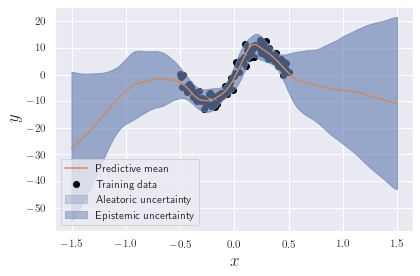

In [11]:
x_test = torch.linspace(-1.5, 1.5, 500).reshape(-1, 1).type(dtype)

y_pred_mean, ale, epi, uncert = pred(models=models, x=x_test)
fig = plot_uncert(x_test=x_test, y_pred_mean=y_pred_mean, x_train=x, y_train=y, 
                  ale=ale, epi=epi, uncert=uncert)
plt.tight_layout()
plt.savefig('reg_sgld.pdf', bbox_inches='tight')

In [14]:
model_lr_std = Model(out_features=1).type(dtype)
model_lr_std.apply(init_uniform)
loss_fct = lambda out, y : gaussian_nll(out[:,0], out[:,1], y[:,0], 'mean')
_, models_lr_std = train(model=model_lr_std, loss_fct=F.mse_loss, x=x, y=y, batch_size=BATCH_SIZE, gamma=GAMMA, glr='std',
                         burnin_iter=BURNIN_ITER, mcmc_iter=MCMC_ITER, lr=LR, num_epochs=NUM_EPOCHS, weight_decay=WEIGHT_DECAY)

loss: 9.518687: 100%|██████████| 3001/3001 [00:18<00:00, 159.57it/s] 


100%|██████████| 10/10 [00:00<00:00, 1499.30it/s]


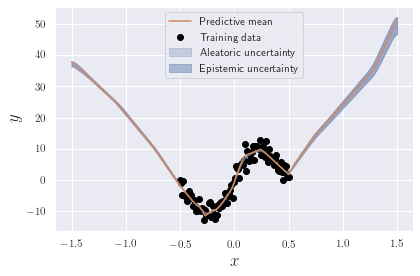

In [15]:
y_pred_mean_lr_std, ale_lr_std, epi_lr_std, uncert_lr_std = pred(models=models_lr_std, x=x_test)
fig = plot_uncert(x_test=x_test, y_pred_mean=y_pred_mean_lr_std, x_train=x, y_train=y, 
                  ale=ale_lr_std, epi=epi_lr_std, uncert=uncert_lr_std)
plt.tight_layout()
plt.savefig('sgld_2eta.pdf', bbox_inches='tight')